In [29]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from predictor import ThroughputPredictor

# Data Loading

In [37]:
def load_dataset(file_path):
  df = pd.read_csv(file_path).dropna()
  df.sort_values(by=['TestID', 'ElapsedTime'], inplace=True)
  
  df['k'] = df['ElapsedTime'] // 100_000
  df['AverageThroughput'] = df['BytesAcked'] / df['ElapsedTime'] * 8
  agg_df = df.groupby(['TestID', 'k'], as_index=False).agg({
    'BytesSent': 'max',
    'BytesAcked': 'max',
    'BytesRetrans': 'max',
    'RTT': 'mean',
    'RTTVar': 'mean',
    'MinRTT': 'min',
    'AverageThroughput': 'max',
    'FinalSpeed': 'max',
  }, inplace=True)
  
  agg_df['DeltaBytesSent'] = agg_df['BytesSent'] - agg_df.groupby('TestID')['BytesSent'].shift(1).fillna(0)
  agg_df['DeltaBytesAcked'] = agg_df['BytesAcked'] - agg_df.groupby('TestID')['BytesAcked'].shift(1).fillna(0)
  agg_df['DeltaBytesRetrans'] = agg_df['BytesRetrans'] - agg_df.groupby('TestID')['BytesRetrans'].shift(1).fillna(0)
  
  agg_df.drop(columns=['TestID'], inplace=True)
  labels = agg_df.pop('FinalSpeed')
  
  return agg_df, labels

In [38]:
features, labels = load_dataset('./dataset.csv')
features

,k,BytesSent,BytesAcked,BytesRetrans,RTT,RTTVar,MinRTT,AverageThroughput,DeltaBytesSent,DeltaBytesAcked,DeltaBytesRetrans
0,0,1547,0,0,100816.00,50408.00,100816,0.000000,1547.0,0.0,0.0
1,1,12847,1547,0,101050.00,28799.00,100816,0.099777,11300.0,1547.0,0.0
2,2,41207,12847,0,106504.25,16665.00,100816,0.414538,28360.0,11300.0,0.0
3,3,80911,41207,0,109021.75,6359.75,100816,0.840475,39704.0,28360.0,0.0
4,4,160319,72403,0,109827.20,4563.20,100816,1.166814,79408.0,31196.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31576,97,1447534832,1337624014,108847318,2000.50,429.00,161,1093.146120,10879832.0,13123108.0,699074.0
31577,98,1476319542,1361344318,111338744,1598.80,307.20,161,1102.809290,28784710.0,23720304.0,2491426.0
31578,100,1476661970,1365289194,111367104,577.50,187.50,161,1083.508932,342428.0,3944876.0,28360.0
31579,101,1477836074,1366463298,111367104,428.75,91.75,161,1079.342364,1174104.0,1174104.0,0.0


In [39]:
X, y = features.values, labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Throughput Predictor

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression = ThroughputPredictor(num_features=len(features.columns))
regression.to(device)
regression.fit(X_train, y_train, epochs=100, batch_size=64, learning_rate=0.02)

Epoch 1/100, Loss: 8474.766030261972
Epoch 2/100, Loss: 1363.99149179183
Epoch 3/100, Loss: 1240.5423460723348
Epoch 4/100, Loss: 1064.2733344921487
Epoch 5/100, Loss: 1155.6196434043047
Epoch 6/100, Loss: 1185.4357262980732
Epoch 7/100, Loss: 1028.3941573214668
Epoch 8/100, Loss: 1064.359939707497
Epoch 9/100, Loss: 1038.9061669807213
Epoch 10/100, Loss: 1128.7247973646042
Epoch 11/100, Loss: 1026.8850331003266
Epoch 12/100, Loss: 1000.1967807064167
Epoch 13/100, Loss: 1057.4469303505957
Epoch 14/100, Loss: 1074.0410672998153
Epoch 15/100, Loss: 950.8198648794538
Epoch 16/100, Loss: 1021.4409778848549
Epoch 17/100, Loss: 990.4385852868846
Epoch 18/100, Loss: 1018.6744218396313
Epoch 19/100, Loss: 927.6314694178586
Epoch 20/100, Loss: 1049.2955215597428
Epoch 21/100, Loss: 973.1745658775285
Epoch 22/100, Loss: 991.5919976647879
Epoch 23/100, Loss: 904.2386653822971
Epoch 24/100, Loss: 989.1438251341009
Epoch 25/100, Loss: 924.070844325027
Epoch 26/100, Loss: 953.9246722756094
Epoch 27/

ThroughputPredictor(
  (stack): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

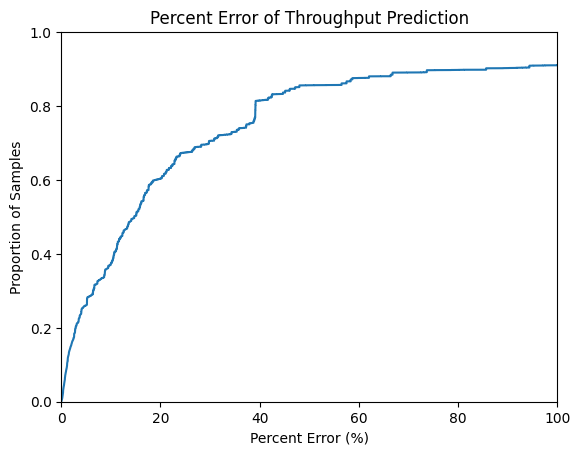

In [45]:
y_pred = regression.predict(X_test)
percent_error = np.abs((y_pred - y_test) / y_test) * 100
ax = plt.axes()
ax.ecdf(percent_error, label='Percent Error')
ax.set_title('Percent Error of Throughput Prediction')
ax.set_xlabel('Percent Error (%)')
ax.set_ylabel('Proportion of Samples')
plt.xlim(0, 100)
plt.show()